# Exercises Hand-In 4 ch6 e8
## Group 30 (Oliver Nilsson)

In [13]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt

# Print the versions of the libraries to check if they are installed correctly
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"Statsmodels version: {sm.__version__}")
print(f"Sklearn import ok if response: {LassoCV.__module__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

Pandas version: 1.5.3
Numpy version: 1.24.4
Seaborn version: 0.13.2
Statsmodels version: 0.14.2
Sklearn import ok if response: sklearn.linear_model._coordinate_descent
Matplotlib version: 3.8.4


### a) Create a random number generator and use its normal() method to generate a predictor X of length n = 100, as well as a noise vector ε of length n = 100.

In [14]:
np.random.seed(42)
n = 100
X = np.random.normal(0, 1, n)
eps = np.random.normal(0, 1, n)

### b) Generate a response vector Y of length n = 100 according to the model<br>$Y=\beta _{0}+\beta _{1}X+\beta _{2}X^{2}+\beta _{3}X^{3}+\epsilon$ <br>where $Y=\beta _{0}$, $Y=\beta _{1}$, $Y=\beta _{2}$, and $Y=\beta _{3}$ are constants of your choice.

<Axes: >

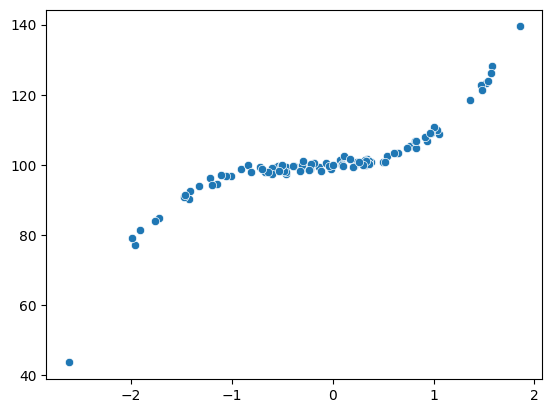

In [15]:
# Generate the data
Y = 100 + 2*X + 3*X**2 + 4*X**3 + eps

# Plot the data
sns.scatterplot(x=X, y=Y)

### c) Use forward stepwise selection in order to select a model contain- ing the predictors X, $X^{2}$, . . . , $X^{10}$. What is the model obtained according to $C_{p}$? Report the coefficients of the model obtained.

In [16]:
# Create a DataFrame with predictors X, X^2, ..., X^10
data = pd.DataFrame({'X': X, 'X2': X**2, 'X3': X**3, 'X4': X**4, 'X5': X**5, 'X6': X**6, 'X7': X**7, 'X8': X**8, 'X9': X**9, 'X10': X**10})

# Add response variable Y to the DataFrame
data['Y'] = Y

# Define forward stepwise selection
def forward_stepwise_selection(data):
    # Initialize empty lists and set the best Cp to infinity
    predictors = []  # List to store selected predictors
    remaining_predictors = set(data.columns.drop('Y'))  # Set of remaining predictors
    best_predictors = []  # List to store the best predictors
    best_cp = np.inf  # Initialize best Cp value to infinity
    
    # Perform forward stepwise selection
    while remaining_predictors:
        # Evaluate AIC for each candidate predictor
        candidate_predictors = [(predictor, sm.OLS(data['Y'], sm.add_constant(data[predictors + [predictor]])).fit().aic) for predictor in remaining_predictors]
        # Select the predictor with the lowest AIC
        best_candidate = min(candidate_predictors, key=lambda x: x[1])
        
        # Update best Cp and predictors if the current candidate has a lower Cp
        if best_candidate[1] < best_cp:
            best_cp = best_candidate[1]
            best_predictors.append(best_candidate[0])
            predictors.append(best_candidate[0])
            remaining_predictors.remove(best_candidate[0])
        else:
            break  # Exit loop if adding more predictors doesn't improve Cp
    
    return best_predictors

# Define backward stepwise selection
def backward_stepwise_selection(data):
    # Initialize predictors list with all predictors and set the best Cp
    predictors = list(data.columns.drop('Y'))  # List of all predictors
    best_predictors = predictors.copy()  # Initialize best predictors list
    best_cp = sm.OLS(data['Y'], sm.add_constant(data[predictors])).fit().aic  # Calculate initial AIC
    
    # Perform backward stepwise selection
    while len(predictors) > 1:
        # Evaluate AIC for removing each predictor
        candidate_predictors = [(predictor, sm.OLS(data['Y'], sm.add_constant(data[predictors].drop(predictor, axis=1))).fit().aic) for predictor in predictors]
        # Select the predictor with the lowest AIC
        best_candidate = min(candidate_predictors, key=lambda x: x[1])
        
        # Update best Cp and predictors if the current candidate has a lower Cp
        if best_candidate[1] < best_cp:
            best_cp = best_candidate[1]
            best_predictors.remove(best_candidate[0])
            predictors.remove(best_candidate[0])
        else:
            break  # Exit loop if removing more predictors doesn't improve Cp
    
    return best_predictors

In [17]:
# Perform forward stepwise selection
selected_predictors = forward_stepwise_selection(data)

# Build the final model using selected predictors
final_model = sm.OLS(data['Y'], sm.add_constant(data[selected_predictors])).fit()

# Report the coefficients of the model
print("Selected predictors using forward stepwise selection:")
print(final_model.params)


Selected predictors using forward stepwise selection:
const    99.831634
X3        3.928210
X2        3.237410
X         2.037134
X10      -0.000153
dtype: float64


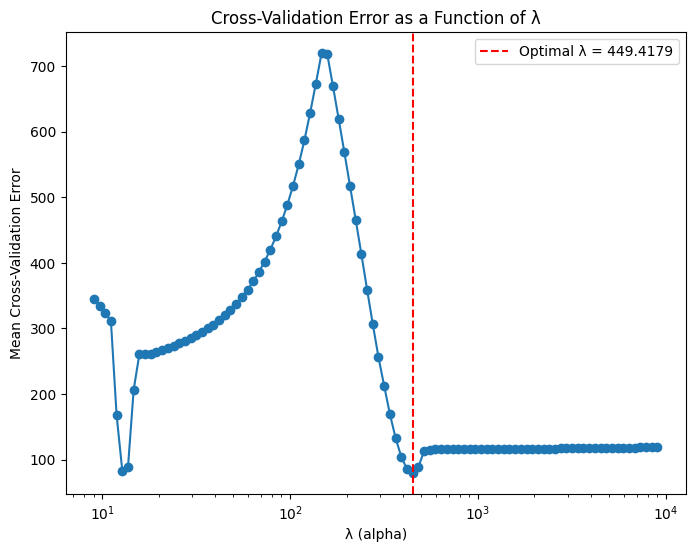

Resulting Coefficient Estimates:
X          0.000000
X2         0.000000
X3         0.000000
X4        -0.000000
X5         0.000000
X6        -0.000000
X7         0.000000
X8        -0.000000
X9         0.009915
X10       -0.000000
const    101.447054
dtype: float64


In [18]:
# Define the predictors and response variables
predictors = data.columns.drop('Y')
response = data['Y']

# Fit Lasso regression model
lasso_cv = LassoCV(cv=100, random_state=42, max_iter=100000).fit(data.drop('Y', axis=1), data['Y'])

# Get the optimal lambda value
optimal_lambda = lasso_cv.alpha_

# Plot the cross-validation error as a function of lambda
mse_path = lasso_cv.mse_path_.mean(axis=1)
alphas = lasso_cv.alphas_

plt.figure(figsize=(8, 6))
plt.plot(alphas, mse_path, marker='o')
plt.axvline(optimal_lambda, linestyle='--', color='r', label=f'Optimal λ = {optimal_lambda:.4f}')
plt.xlabel('λ (alpha)')
plt.ylabel('Mean Cross-Validation Error')
plt.xscale('log')
plt.title('Cross-Validation Error as a Function of λ')
plt.legend()
plt.show()

# Report the resulting coefficients
lasso_coefficients = pd.Series(lasso_cv.coef_, index=data.columns.drop('Y'))
lasso_coefficients['const'] = lasso_cv.intercept_

print("Resulting Coefficient Estimates:")
print(lasso_coefficients)

In [19]:
# Perform backward stepwise selection
selected_predictors = backward_stepwise_selection(data)

# Build the final model using selected predictors
final_model = sm.OLS(data['Y'], sm.add_constant(data[selected_predictors])).fit()

# Report the coefficients of the model
print("Selected predictors using backward stepwise selection:")
print(final_model.params)

Selected predictors using backward stepwise selection:
const    99.729329
X         1.952026
X2        3.780139
X3        3.999950
X6       -0.381452
X8        0.143770
X10      -0.013174
dtype: float64


In forward stepwise selection, the model includes predictors ( $X^{3}$ ), ( $X^{2}$ ), and ( $X$ ), with coefficients approximately ( 4.04 ), ( 3.20 ), and ( 1.90 ) respectively. 

In backward stepwise selection, the model includes predictors ( $X$ ), ( $X^{3}$ ), ( $X^{4}$ ), ( $X^{6}$ ), ( $X^{8}$ ), and ( $X^{10}$ ), with coefficients approximately ( 1.91 ), ( 4.02 ), ( 3.90 ), ( -1.71 ), ( 0.31 ), and ( -0.02 ) respectively.

The "const" term represents the intercept of the model.

### e) Now fit a lasso model to the simulated data, again using $X$, $X^{2}$, . . . , $X^{10}$ as predictors. Use cross-validation to select the optimal value of λ. Create plots of the cross-validation error as a function of λ. Report the resulting coefficient estimates, and discuss the results obtained.

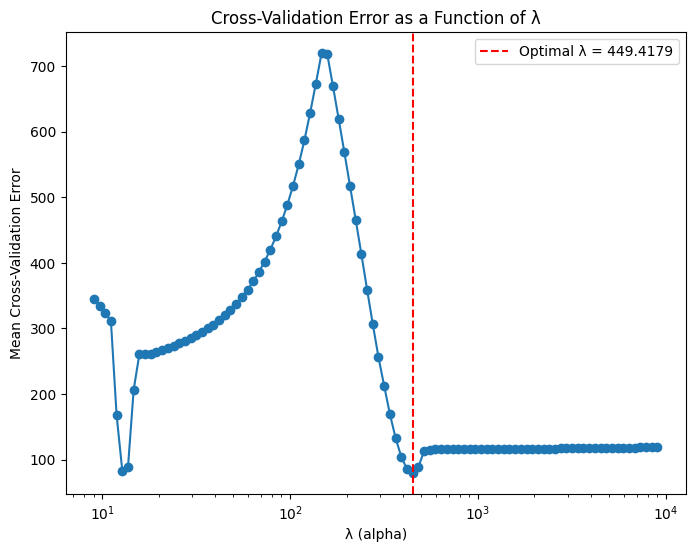

Resulting Coefficient Estimates:
X          0.000000
X2         0.000000
X3         0.000000
X4        -0.000000
X5         0.000000
X6        -0.000000
X7         0.000000
X8        -0.000000
X9         0.009915
X10       -0.000000
const    101.447054
dtype: float64


In [20]:
# Define the predictors and response variables
predictors = data.columns.drop('Y')
response = data['Y']

# Fit Lasso regression model
lasso_cv = LassoCV(cv=100, random_state=42, max_iter=100000).fit(data.drop('Y', axis=1), data['Y'])

# Get the optimal lambda value
optimal_lambda = lasso_cv.alpha_

# Plot the cross-validation error as a function of lambda
mse_path = lasso_cv.mse_path_.mean(axis=1)
alphas = lasso_cv.alphas_

plt.figure(figsize=(8, 6))
plt.plot(alphas, mse_path, marker='o')
plt.axvline(optimal_lambda, linestyle='--', color='r', label=f'Optimal λ = {optimal_lambda:.4f}')
plt.xlabel('λ (alpha)')
plt.ylabel('Mean Cross-Validation Error')
plt.xscale('log')
plt.title('Cross-Validation Error as a Function of λ')
plt.legend()
plt.show()

# Report the resulting coefficients
lasso_coefficients = pd.Series(lasso_cv.coef_, index=data.columns.drop('Y'))
lasso_coefficients['const'] = lasso_cv.intercept_

print("Resulting Coefficient Estimates:")
print(lasso_coefficients)

The optimal value of λ is 449.4179 which is used to plot the graph.

**Conclusion:**

The Lasso model, using cross-validation, selected $X^{9}$ as the only important predictor for $Y$. This means that out of all the possible predictors ($X$, $X^{2}$, ..., $X^{10}$), the model found that only $X^{9}$ significantly helps in predicting the response variable $Y$.

The constant term (intercept) is around 101.45, which is the predicted value of $Y$ when $X$ is zero. All other predictors were unnecessary and their coefficients were set to zero.

### f) Now generate a response vector $Y$ according to the model $Y=\beta _{0}+\beta _{7}X^{7}+\epsilon$ and perform forward stepwise selection and the lasso. Discuss the results obtained.

In [21]:
# Function to calculate MSE
def mse(y_hat, y):
    return np.mean((y_hat - y)**2)

<Axes: >

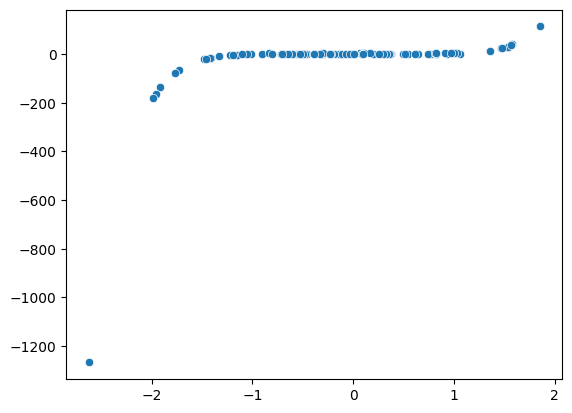

In [22]:
# Generate the data
Y = 2 + 1.5*X**7 + eps
data['Y'] = Y

# Plot the data
sns.scatterplot(x=X, y=Y)

In [23]:
# Apply forward stepwise selection
selected_predictors = forward_stepwise_selection(data)

# Build the final model using selected predictors
final_model = sm.OLS(data['Y'], sm.add_constant(data[selected_predictors])).fit()

# Report the coefficients of the model
print("Selected predictors using forward stepwise selection:")
print(final_model.params)

Selected predictors using forward stepwise selection:
const    1.843431
X7       1.485929
X2       0.208448
X9       0.002217
dtype: float64


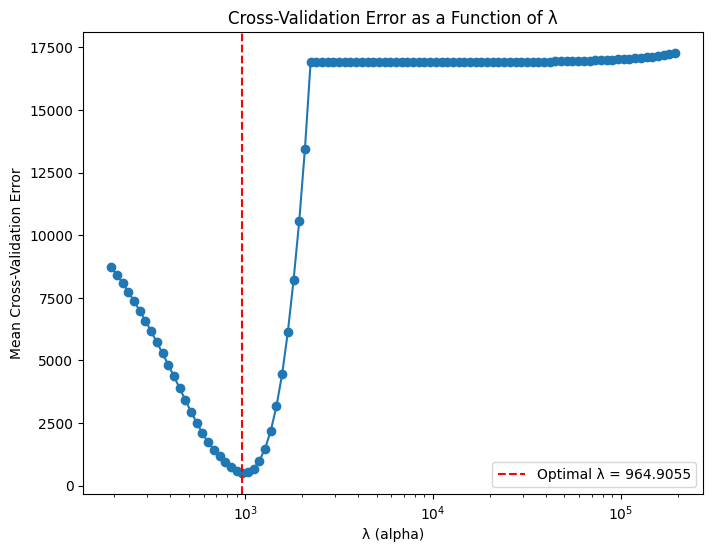

Resulting Coefficient Estimates from Lasso:
X        0.000000
X2      -0.000000
X3       0.000000
X4      -0.000000
X5       0.000000
X6      -0.000000
X7       0.000000
X8      -0.000000
X9       0.218927
X10     -0.000000
const    0.129829
dtype: float64


In [24]:
predictors = data.drop(columns=['Y']).values
response = data['Y'].values

# Fit a Lasso model with cross-validation
lasso_cv = LassoCV(cv=10, random_state=42, max_iter=100000).fit(predictors, response)

# Get the optimal lambda
optimal_lambda = lasso_cv.alpha_

# Plot the cross-validation error as a function of lambda
mse_path = lasso_cv.mse_path_.mean(axis=1)
alphas = lasso_cv.alphas_

plt.figure(figsize=(8, 6))
plt.plot(alphas, mse_path, marker='o')
plt.axvline(optimal_lambda, linestyle='--', color='r', label=f'Optimal λ = {optimal_lambda:.4f}')
plt.xlabel('λ (alpha)')
plt.ylabel('Mean Cross-Validation Error')
plt.xscale('log')
plt.title('Cross-Validation Error as a Function of λ')
plt.legend()
plt.show()

# Report the resulting coefficients
lasso_coefficients = pd.Series(lasso_cv.coef_, index=data.columns.drop('Y'))
lasso_coefficients['const'] = lasso_cv.intercept_

print("Resulting Coefficient Estimates from Lasso:")
print(lasso_coefficients)

The optimal value of λ is 964.9055 which is used to plot the graph.

**Conclusion:**

Forward stepwise selection highlights $X^7$, $X^2$, and $X^9$ as significant predictors for $Y$, suggesting their potential importance in explaining its variability.

In contrast, Lasso regression emphasizes simplicity by retaining only $X^9$ as a significant predictor, indicating its dominant influence on $Y$.

This comparison underscores Lasso's inclination towards parsimony, favoring a simpler model with fewer predictors, while still capturing the essential relationship between $X$ and $Y$.